In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from forex_python.converter import CurrencyRates
from pypfopt import EfficientFrontier, plotting
import math
import scipy.optimize as sco

## Actual portfolio

In [2]:
portfolio = ['ECOPETROL.CL', 'GEB.CL', 'PFCIBEST.CL', 'CIBEST.CL', 'GOOGL', 'AAPL', 'BVC.CL', 'NKE','IVV']

In [3]:
stock_prices = pd.DataFrame()
stock_returns = pd.DataFrame()

today_date = datetime.now()
end = today_date.strftime('%Y-%m-%d')

for x in portfolio:
    stock = yf.Ticker(x)
    close_price = stock.history(start='2021-01-01', end=end)['Close']

    stock_prices = pd.concat([stock_prices, close_price], axis=1)

    stock_returns = pd.concat([stock_returns, close_price.pct_change()], axis=1)

stock_prices.columns = portfolio
stock_returns.columns = portfolio

stock_prices = stock_prices.dropna()
stock_returns = stock_returns.dropna()

In [4]:
# Descargar el histórico del dólar (USD a COP)
usd_cop = yf.Ticker("COP=X").history(start='2021-01-01', end=end)['Close']

# Asegurar que los índices coincidan con tus stock_prices
usd_cop = usd_cop.reindex(stock_prices.index, method='ffill')

In [5]:
# Lista de tickers que están en USD y quieres pasar a COP
stocks_en_usd = ['AAPL', 'IVV', 'GOOGL', 'NKE'] # Ajusta según tu caso

# Aplicar la conversión solo a esas columnas
for ticker in stocks_en_usd:
    if ticker in stock_prices.columns:
        stock_prices[ticker] = stock_prices[ticker] * usd_cop

In [6]:
stock_prices.head()

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
2021-01-04 00:00:00-05:00,1157.895508,1699.219238,21898.806641,22459.773438,292976.174648,430864.188015,7506.622070,446223.895313,1.179055e+06
2021-01-05 00:00:00-05:00,1183.718384,1715.099854,21905.248047,23914.628906,297713.443977,439698.418699,7557.256836,453439.835197,1.196401e+06
2021-01-06 00:00:00-05:00,1191.981689,1708.747681,22001.888672,22862.037109,294305.494282,424219.599861,7557.256836,456306.489956,1.201704e+06
2021-01-07 00:00:00-05:00,1225.551392,1626.803833,22240.269531,23002.832031,300502.913174,434942.087986,7772.456055,460665.776733,1.209059e+06
2021-01-08 00:00:00-05:00,1238.979126,1628.074341,22401.339844,23532.476562,311211.701100,448393.674105,8038.288574,475396.449859,1.242834e+06


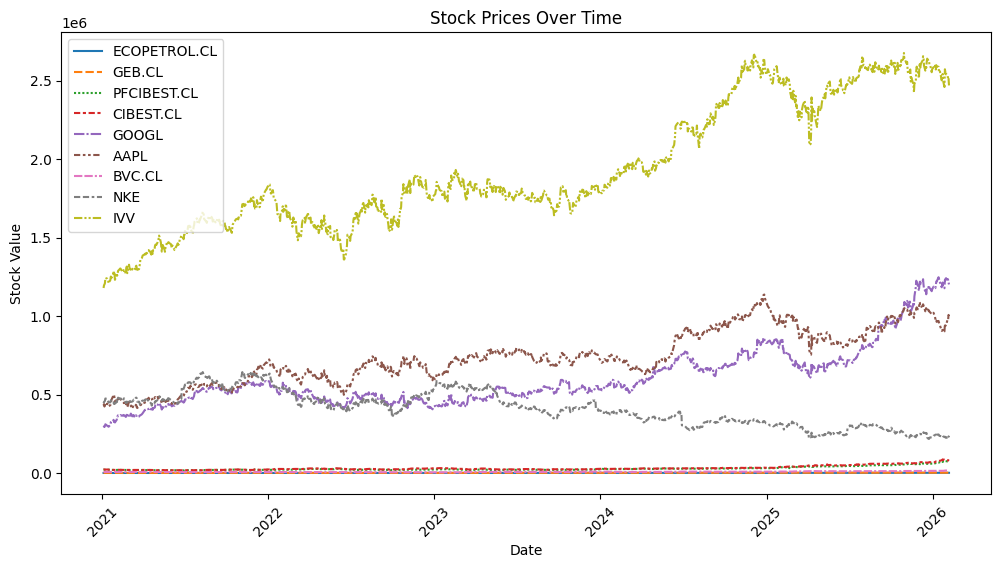

In [7]:
plt.figure(figsize=(12,6))

sns.lineplot(data=stock_prices)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.title('Stock Prices Over Time')
plt.savefig('stock_prices_over_time.png')
plt.show()

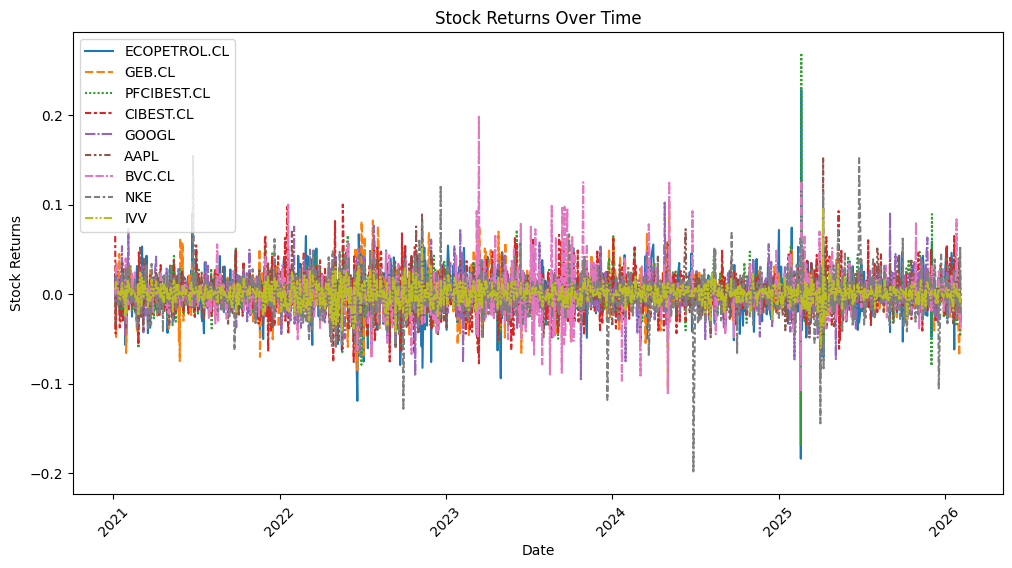

In [8]:
plt.figure(figsize=(12,6))

sns.lineplot(data=stock_returns)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
plt.savefig('stock_returns_over_time.png')
plt.show()

In [9]:
expected_stock_returns = []
individual_stock_risk = []

for x, y in stock_returns.items():
    expected_stock_returns.append(y.mean())

    individual_stock_risk.append(y.std())

In [10]:
print(f"Mean return (percent)")

for name, value in zip(portfolio, expected_stock_returns):
    print(f"\t{name}: \t{value}%")

Mean return (percent)
	ECOPETROL.CL: 	0.0007238301600181363%
	GEB.CL: 	0.0005059713508386344%
	PFCIBEST.CL: 	0.0012144129638973426%
	CIBEST.CL: 	0.0013226509005973997%
	GOOGL: 	0.0010974499781620088%
	AAPL: 	0.0005926022813457648%
	BVC.CL: 	0.0008683794443304066%
	NKE: 	-0.0003847563199024757%
	IVV: 	0.00047080093442603856%


In [11]:
print(f"Risk (Std. Dev)")

for name, value in zip(portfolio, individual_stock_risk):
    print(f"\t{name}: \t{value}")

Risk (Std. Dev)
	ECOPETROL.CL: 	0.023287435591030727
	GEB.CL: 	0.01922943726742322
	PFCIBEST.CL: 	0.019984190084534594
	CIBEST.CL: 	0.02161112120164395
	GOOGL: 	0.019722061135184026
	AAPL: 	0.017720774764735478
	BVC.CL: 	0.021667935960996035
	NKE: 	0.022145407051641884
	IVV: 	0.01078354312901344


In [12]:
expected_stock_returns = np.array(pd.DataFrame(expected_stock_returns))
individual_stock_risk = np.array(pd.DataFrame(individual_stock_risk))

stock_returns_cov_matrix = np.array(stock_returns.cov())

In [13]:
stock_returns_cov_matrix

array([[ 5.42304656e-04,  1.13369578e-04,  2.28984453e-04,
         1.11584329e-04,  5.16889819e-05,  6.41289609e-05,
         8.02315012e-05,  8.24058925e-05,  5.76363538e-05],
       [ 1.13369578e-04,  3.69771258e-04,  7.92658568e-05,
         5.54112048e-05,  2.97093382e-05,  1.66815602e-05,
         7.04152673e-05,  3.68748609e-05,  3.00085534e-05],
       [ 2.28984453e-04,  7.92658568e-05,  3.99367853e-04,
         2.24628891e-04,  5.12325818e-05,  5.62807388e-05,
         7.95395126e-05,  6.96367756e-05,  5.14990220e-05],
       [ 1.11584329e-04,  5.54112048e-05,  2.24628891e-04,
         4.67040560e-04,  3.19949039e-05,  2.31405915e-05,
        -1.27916239e-05,  4.04271212e-05,  3.20584190e-05],
       [ 5.16889819e-05,  2.97093382e-05,  5.12325818e-05,
         3.19949039e-05,  3.88959695e-04,  2.04835610e-04,
         3.26045568e-05,  1.57910021e-04,  1.47160243e-04],
       [ 6.41289609e-05,  1.66815602e-05,  5.62807388e-05,
         2.31405915e-05,  2.04835610e-04,  3.140258

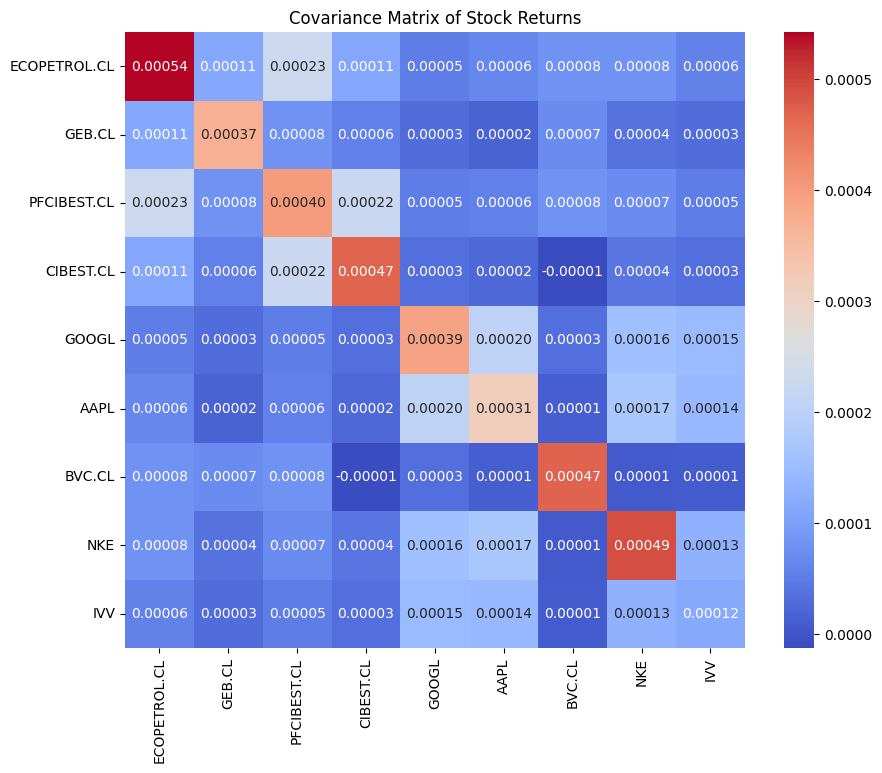

In [14]:
cov_matrix_df = stock_returns.cov()

plt.figure(figsize=(10,8))

sns.heatmap(cov_matrix_df, annot=True, fmt=".5f", cmap='coolwarm')

plt.title('Covariance Matrix of Stock Returns')
plt.savefig('covariance_matrix_stock_returns.png')
plt.show()

In [15]:
cov_matrix_df

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
ECOPETROL.CL,0.000542,0.000113,0.000229,0.000112,0.000052,0.000064,0.000080,0.000082,0.000058
GEB.CL,0.000113,0.000370,0.000079,0.000055,0.000030,0.000017,0.000070,0.000037,0.000030
PFCIBEST.CL,0.000229,0.000079,0.000399,0.000225,0.000051,0.000056,0.000080,0.000070,0.000051
CIBEST.CL,0.000112,0.000055,0.000225,0.000467,0.000032,0.000023,-0.000013,0.000040,0.000032
GOOGL,0.000052,0.000030,0.000051,0.000032,0.000389,0.000205,0.000033,0.000158,0.000147
AAPL,0.000064,0.000017,0.000056,0.000023,0.000205,0.000314,0.000010,0.000174,0.000145
BVC.CL,0.000080,0.000070,0.000080,-0.000013,0.000033,0.000010,0.000469,0.000006,0.000009
NKE,0.000082,0.000037,0.000070,0.000040,0.000158,0.000174,0.000006,0.000490,0.000129
IVV,0.000058,0.000030,0.000051,0.000032,0.000147,0.000145,0.000009,0.000129,0.000116


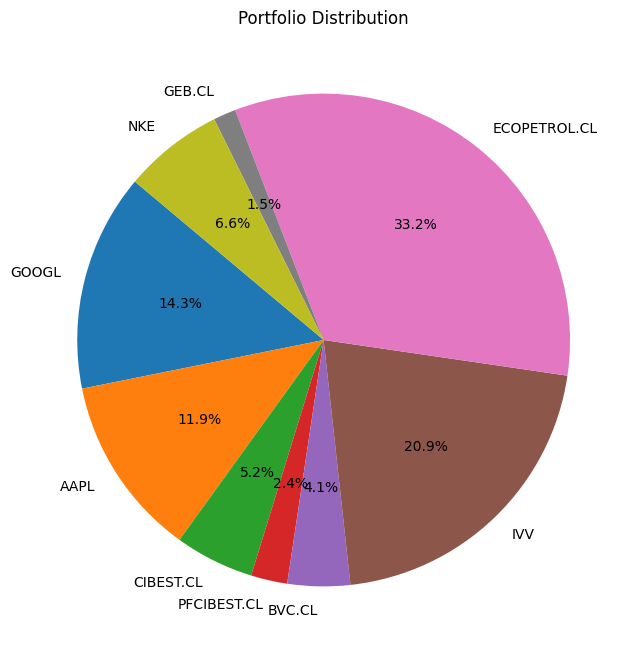

In [16]:
# 1. Definición de activos y cantidades (Excluyendo IUIT)
portfolio_data = {
    "GOOGL": 7,
    "AAPL": 7,
    "CIBEST.CL": 39,
    "PFCIBEST.CL": 20,
    "BVC.CL": 154,
    "IVV": 5,
    "ECOPETROL.CL": 9006,
    "GEB.CL": 308,
    "NKE": 17
}

# 2. Selección del último día de precios
# Asumiendo que 'df_precios' es tu DataFrame con las series de tiempo
last_prices = stock_prices.iloc[-1]

# 3. Cálculo del valor actual y pesos
portfolio_values = {ticker: last_prices[ticker] * qty for ticker, qty in portfolio_data.items()}
total_value = sum(portfolio_values.values())
weights = {ticker: val / total_value for ticker, val in portfolio_values.items()}

#Pie plot of portfolio distribution
plt.figure(figsize=(8,8))
plt.pie(weights.values(), labels=weights.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Distribution')
plt.savefig('portfolio_distribution.png')
plt.show()

In [17]:
ef = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0,1))
ratios = ef.min_volatility()
cleaned_ratios = pd.Series(ratios)
cleaned_ratios.index = portfolio

optimal_portfolio = np.expand_dims(cleaned_ratios, axis=0)

# Rendimiento esperado
opt_portfolio_expected_return = np.matmul(optimal_portfolio, expected_stock_returns)

# Varianza del portafolio
opt_portfolio_var = np.matmul(optimal_portfolio, \
                              np.matmul(stock_returns_cov_matrix, optimal_portfolio.transpose()))

# Riesgo del portafolio
opt_portfolio_risk = math.sqrt(opt_portfolio_var)

# Ver datos obtenidos y Portafolio Óptimo de Markowitz:
print('PORTAFOLIO ÓPTIMO DE MARKOWITZ:')
print(f'Rendimiento esperado: {opt_portfolio_expected_return*100}')
print(f'Varianza del portafolio: {opt_portfolio_var*100}')
print(f'Riesgo del portafolio: {opt_portfolio_risk*100}')

print('\n\nDel 100% de tu capital, el modelo sugiere\
invertir las siguientes proporciones en cada activo:')
display(cleaned_ratios*100)
     


PORTAFOLIO ÓPTIMO DE MARKOWITZ:
Rendimiento esperado: [[0.06341441]]
Varianza del portafolio: [[0.00801558]]
Riesgo del portafolio: 0.8952976870881858


Del 100% de tu capital, el modelo sugiereinvertir las siguientes proporciones en cada activo:


C:\Users\jaayg\AppData\Local\Temp\ipykernel_14372\1680248768.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt_portfolio_risk = math.sqrt(opt_portfolio_var)


ECOPETROL.CL     1.321045
GEB.CL          11.871147
PFCIBEST.CL      0.000000
CIBEST.CL       11.646680
GOOGL            0.000000
AAPL             0.000000
BVC.CL          14.239490
NKE              0.000000
IVV             60.921638
dtype: float64

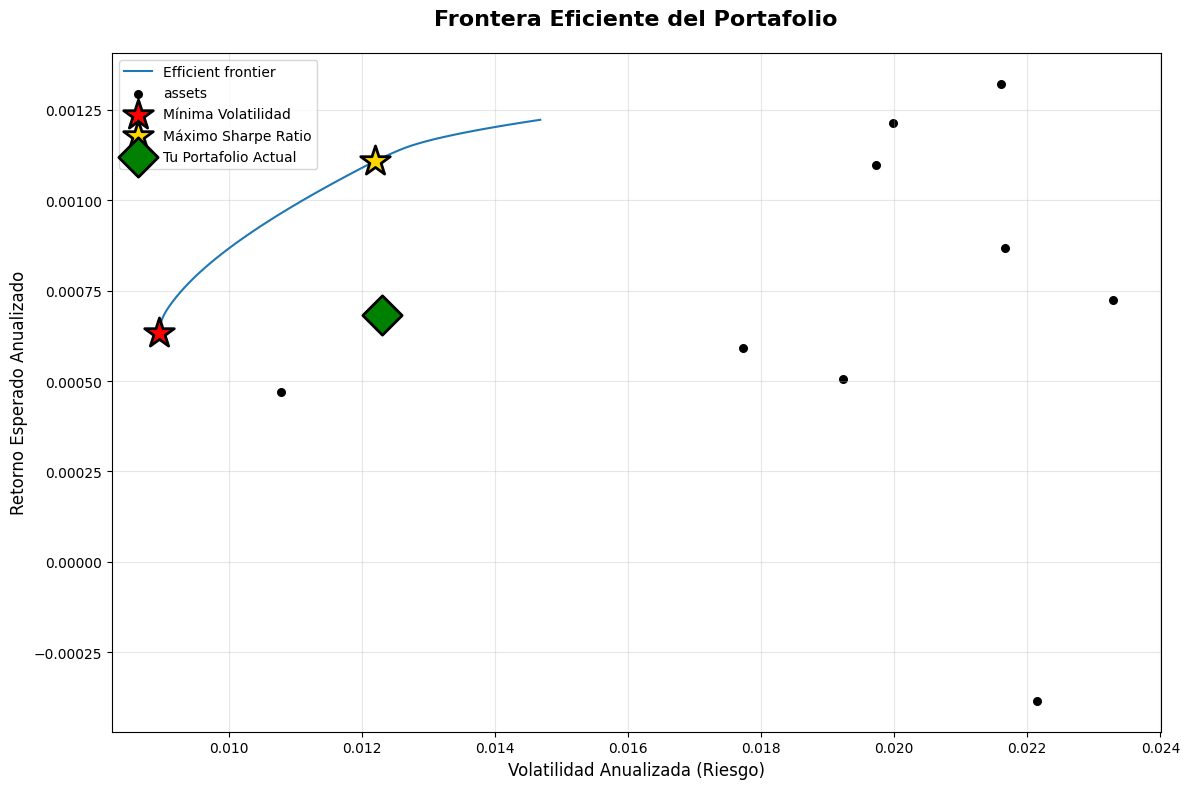

In [18]:
# Crear la frontera eficiente inicial para graficar
ef = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0, 1))

# Crear figura
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar la frontera eficiente
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# 1. Portafolio de mínima volatilidad
ef_min_vol = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0, 1))
ef_min_vol.min_volatility()
ret_min_vol, std_min_vol, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_min_vol, ret_min_vol, marker='*', s=500, c='red', 
           label='Mínima Volatilidad', edgecolors='black', linewidths=2, zorder=3)

# 2. Portafolio de máximo Sharpe Ratio
ef_max_sharpe = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0, 1))
ef_max_sharpe.max_sharpe()
ret_max_sharpe, std_max_sharpe, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_max_sharpe, ret_max_sharpe, marker='*', s=500, c='gold', 
           label='Máximo Sharpe Ratio', edgecolors='black', linewidths=2, zorder=3)

# 3. Tu portafolio actual
if weights is not None:
    # Convertir pesos a array en el orden correcto
    weights_array = np.array([weights.get(ticker, 0) for ticker in stock_returns.columns])
    
    # Calcular retorno esperado del portafolio
    ret_actual = np.dot(weights_array, expected_stock_returns)
    
    # Calcular volatilidad del portafolio
    std_actual = np.sqrt(np.dot(weights_array, np.dot(cov_matrix_df, weights_array)))
    
    ax.scatter(std_actual, ret_actual, marker='D', s=400, c='green', 
               label='Tu Portafolio Actual', edgecolors='black', linewidths=2, zorder=3)

# Configurar el gráfico
ax.set_title('Frontera Eficiente del Portafolio', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Volatilidad Anualizada (Riesgo)', fontsize=12)
ax.set_ylabel('Retorno Esperado Anualizado', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('frontera_eficiente.png', dpi=300, bbox_inches='tight')
plt.show()

## Portfolio simulation

In [19]:
portfolio = ['ECOPETROL.CL', 'GEB.CL', 'PFCIBEST.CL', 'CIBEST.CL', 'GOOGL', 'AAPL', 'BVC.CL', 'NKE','IVV']

In [20]:
# Lista de tickers que están en USD y quieres pasar a COP
stocks_en_usd = ['AAPL', 'IVV', 'GOOGL', 'NKE'] # Ajusta según tu caso

In [21]:
def calcular_pesos_minima_volatilidad(returns):
    """
    Calcula los pesos óptimos usando mínima volatilidad
    """
    expected_returns = returns.mean()
    cov_matrix = returns.cov()
    
    ef = EfficientFrontier(expected_returns, cov_matrix, weight_bounds=(0,1))
    pesos = ef.min_volatility()
    
    return pd.Series(pesos)

In [22]:
def descargar_precios(portfolio, start_date, end_date, stocks_en_usd):
    """
    Descarga precios y convierte USD a COP
    """
    stock_prices = pd.DataFrame()
    
    # Descargar precios de acciones
    for ticker in portfolio:
        stock = yf.Ticker(ticker)
        close_price = stock.history(start=start_date, end=end_date)['Close']
        stock_prices = pd.concat([stock_prices, close_price], axis=1)
    
    stock_prices.columns = portfolio
    
    # Descargar tipo de cambio USD/COP
    usd_cop = yf.Ticker("COP=X").history(start=start_date, end=end_date)['Close']
    usd_cop = usd_cop.reindex(stock_prices.index, method='ffill')
    
    # Convertir acciones en USD a COP
    for ticker in stocks_en_usd:
        if ticker in stock_prices.columns:
            stock_prices[ticker] = stock_prices[ticker] * usd_cop
    
    stock_prices = stock_prices.dropna()
    
    return stock_prices

In [23]:
def backtest_rebalanceo(portfolio, stocks_en_usd, fecha_inicio_entrenamiento, 
                        fecha_inicio_backtest, fecha_fin_backtest, 
                        meses_rebalanceo, inversion_inicial=10000000):
    """
    Realiza backtesting con rebalanceo periódico
    
    Parámetros:
    - meses_rebalanceo: 3 (trimestral), 6 (semestral), 12 (anual)
    - inversion_inicial: capital inicial en COP
    """
    
    # Descargar datos de entrenamiento
    precios_entrenamiento = descargar_precios(
        portfolio, 
        fecha_inicio_entrenamiento, 
        fecha_inicio_backtest,
        stocks_en_usd
    )
    
    # Descargar datos de backtest
    precios_backtest = descargar_precios(
        portfolio,
        fecha_inicio_backtest,
        fecha_fin_backtest,
        stocks_en_usd
    )
    
    # Calcular retornos para entrenamiento inicial
    retornos_entrenamiento = precios_entrenamiento.pct_change().dropna()
    
    # Calcular pesos iniciales
    pesos_actuales = calcular_pesos_minima_volatilidad(retornos_entrenamiento)
    
    # Inicializar portafolio
    valor_portafolio = [inversion_inicial]
    fechas_rebalanceo = [precios_backtest.index[0]]
    historial_pesos = [pesos_actuales.to_dict()]
    
    # Variables para tracking
    ultima_fecha_rebalanceo = precios_backtest.index[0]
    precio_inicial = precios_backtest.iloc[0]
    acciones = (pesos_actuales * inversion_inicial) / precio_inicial
    
    # Iterar sobre cada día del período de backtest
    for i in range(1, len(precios_backtest)):
        fecha_actual = precios_backtest.index[i]
        precios_actual = precios_backtest.iloc[i]
        
        # Calcular valor actual del portafolio
        valor_actual = (acciones * precios_actual).sum()
        valor_portafolio.append(valor_actual)
        
        # Verificar si toca rebalancear
        meses_transcurridos = (fecha_actual.year - ultima_fecha_rebalanceo.year) * 12 + \
                              (fecha_actual.month - ultima_fecha_rebalanceo.month)
        
        if meses_transcurridos >= meses_rebalanceo:
            # Actualizar datos de entrenamiento hasta la fecha actual
            precios_entrenamiento_actual = descargar_precios(
                portfolio,
                fecha_inicio_entrenamiento,
                fecha_actual.strftime('%Y-%m-%d'),
                stocks_en_usd
            )
            
            retornos_entrenamiento_actual = precios_entrenamiento_actual.pct_change().dropna()
            
            # Recalcular pesos óptimos
            pesos_actuales = calcular_pesos_minima_volatilidad(retornos_entrenamiento_actual)
            
            # Rebalancear: vender todo y comprar según nuevos pesos
            acciones = (pesos_actuales * valor_actual) / precios_actual
            
            # Guardar información del rebalanceo
            ultima_fecha_rebalanceo = fecha_actual
            fechas_rebalanceo.append(fecha_actual)
            historial_pesos.append(pesos_actuales.to_dict())

    resultados = pd.DataFrame({
        'Valor_Portafolio': valor_portafolio
    }, index=precios_backtest.index)
    
    resultados['Retorno_Acumulado'] = (resultados['Valor_Portafolio'] / inversion_inicial - 1) * 100
    resultados['Retorno_Diario'] = resultados['Valor_Portafolio'].pct_change()
    
    # Métricas de desempeño
    retorno_total = (valor_portafolio[-1] / inversion_inicial - 1) * 100
    retorno_anualizado = ((valor_portafolio[-1] / inversion_inicial) ** 
                          (252 / len(precios_backtest)) - 1) * 100
    volatilidad_anualizada = resultados['Retorno_Diario'].std() * np.sqrt(252) * 100
    sharpe_ratio = retorno_anualizado / volatilidad_anualizada if volatilidad_anualizada > 0 else 0
    
    # Drawdown
    cummax = resultados['Valor_Portafolio'].cummax()
    drawdown = (resultados['Valor_Portafolio'] - cummax) / cummax * 100
    max_drawdown = drawdown.min()
    
    metricas = {
        'Retorno Total (%)': retorno_total,
        'Retorno Anualizado (%)': retorno_anualizado,
        'Volatilidad Anualizada (%)': volatilidad_anualizada,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Num Rebalanceos': len(fechas_rebalanceo) - 1
    }
    
    return resultados, metricas, fechas_rebalanceo, historial_pesos

Ejecutando backtests...

1. REBALANCEO TRIMESTRAL (cada 3 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 119.33
Retorno Anualizado (%): 31.10
Volatilidad Anualizada (%): 17.13
Sharpe Ratio: 1.82
Max Drawdown (%): -11.25
Num Rebalanceos: 12.00

2. REBALANCEO SEMESTRAL (cada 6 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 121.80
Retorno Anualizado (%): 31.60
Volatilidad Anualizada (%): 17.31
Sharpe Ratio: 1.83
Max Drawdown (%): -11.25
Num Rebalanceos: 6.00

3. REBALANCEO ANUAL (cada 12 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 129.68
Retorno Anualizado (%): 33.20
Volatilidad Anualizada (%): 18.73
Sharpe Ratio: 1.77
Max Drawdown (%): -14.01
Num Rebalanceos: 3.00

4. BUY AND HOLD (sin rebalanceo)
--------------------------------------------------------------------------------
Retorno Total (%): 124.30
Retor

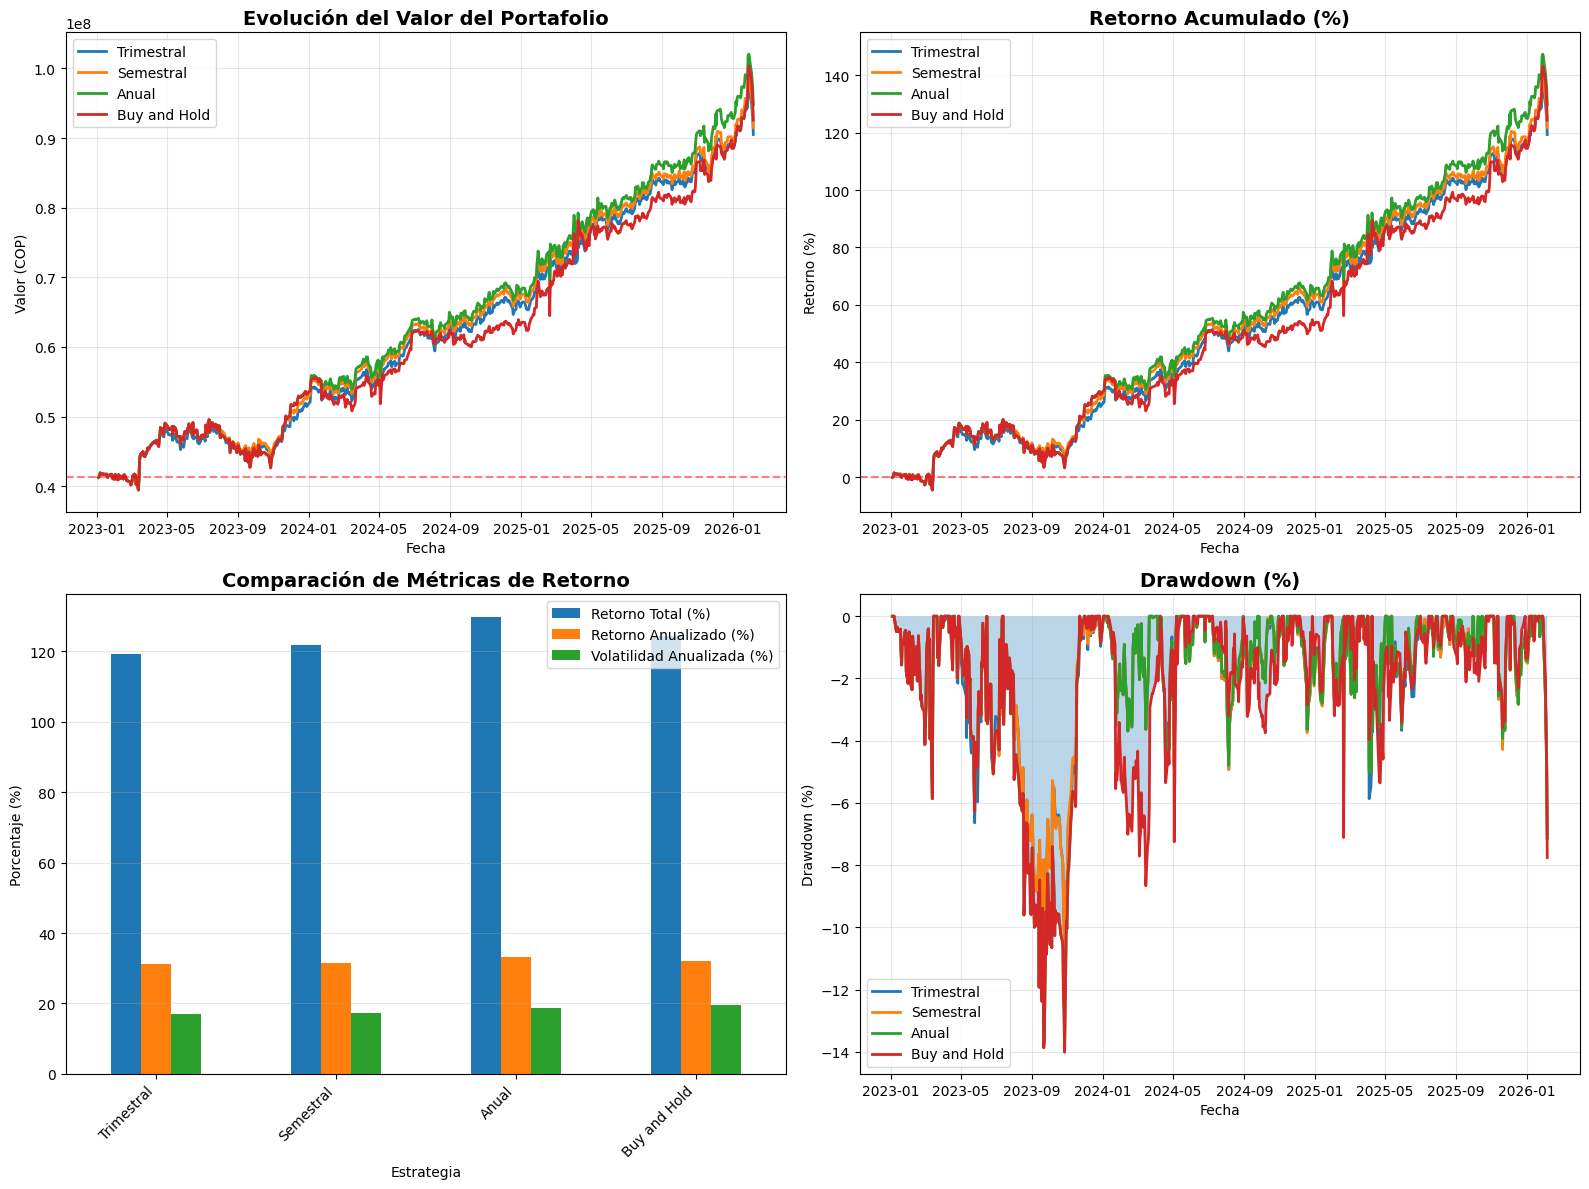


TABLA RESUMEN DE MÉTRICAS
                            Trimestral  Semestral   Anual  Buy and Hold
Retorno Total (%)               119.33     121.80  129.68        124.30
Retorno Anualizado (%)           31.10      31.60   33.20         32.11
Volatilidad Anualizada (%)       17.13      17.31   18.73         19.53
Sharpe Ratio                      1.82       1.83    1.77          1.64
Max Drawdown (%)                -11.25     -11.25  -14.01        -14.01
Num Rebalanceos                  12.00       6.00    3.00          0.00


In [24]:
# EJECUTAR BACKTESTS CON DIFERENTES FRECUENCIAS
print("Ejecutando backtests...")
print("=" * 80)

# Parámetros
fecha_inicio_entrenamiento = '2021-01-01'
fecha_inicio_backtest = '2023-01-01'
fecha_fin_backtest = datetime.now().strftime('%Y-%m-%d')
inversion_inicial = 41267106  # 41,267,106 COP

# Diccionario para almacenar resultados
resultados_todos = {}

# 1. Rebalanceo trimestral (cada 3 meses)
print("\n1. REBALANCEO TRIMESTRAL (cada 3 meses)")
print("-" * 80)
resultados_3m, metricas_3m, fechas_reb_3m, pesos_3m = backtest_rebalanceo(
    portfolio, stocks_en_usd, 
    fecha_inicio_entrenamiento, 
    fecha_inicio_backtest, 
    fecha_fin_backtest,
    meses_rebalanceo=3,
    inversion_inicial=inversion_inicial
)
resultados_todos['Trimestral'] = resultados_3m
for metrica, valor in metricas_3m.items():
    print(f"{metrica}: {valor:.2f}")

# 2. Rebalanceo semestral (cada 6 meses)
print("\n2. REBALANCEO SEMESTRAL (cada 6 meses)")
print("-" * 80)
resultados_6m, metricas_6m, fechas_reb_6m, pesos_6m = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=6,
    inversion_inicial=inversion_inicial
)
resultados_todos['Semestral'] = resultados_6m
for metrica, valor in metricas_6m.items():
    print(f"{metrica}: {valor:.2f}")

# 3. Rebalanceo anual (cada 12 meses)
print("\n3. REBALANCEO ANUAL (cada 12 meses)")
print("-" * 80)
resultados_12m, metricas_12m, fechas_reb_12m, pesos_12m = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=12,
    inversion_inicial=inversion_inicial
)
resultados_todos['Anual'] = resultados_12m
for metrica, valor in metricas_12m.items():
    print(f"{metrica}: {valor:.2f}")

# 4. Buy and Hold (sin rebalanceo)
print("\n4. BUY AND HOLD (sin rebalanceo)")
print("-" * 80)
resultados_bh, metricas_bh, fechas_reb_bh, pesos_bh = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=999,  # Número grande para evitar rebalanceos
    inversion_inicial=inversion_inicial
)
resultados_todos['Buy and Hold'] = resultados_bh
for metrica, valor in metricas_bh.items():
    print(f"{metrica}: {valor:.2f}")

# VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolución del valor del portafolio
ax1 = axes[0, 0]
for nombre, resultado in resultados_todos.items():
    ax1.plot(resultado.index, resultado['Valor_Portafolio'], label=nombre, linewidth=2)
ax1.set_title('Evolución del Valor del Portafolio', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Valor (COP)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=inversion_inicial, color='red', linestyle='--', alpha=0.5, label='Inversión Inicial')

# 2. Retorno acumulado
ax2 = axes[0, 1]
for nombre, resultado in resultados_todos.items():
    ax2.plot(resultado.index, resultado['Retorno_Acumulado'], label=nombre, linewidth=2)
ax2.set_title('Retorno Acumulado (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Retorno (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 3. Comparación de métricas
ax3 = axes[1, 0]
metricas_comparacion = pd.DataFrame({
    'Trimestral': metricas_3m,
    'Semestral': metricas_6m,
    'Anual': metricas_12m,
    'Buy and Hold': metricas_bh
})
metricas_comparacion.loc[['Retorno Total (%)', 'Retorno Anualizado (%)', 
                           'Volatilidad Anualizada (%)']].T.plot(kind='bar', ax=ax3)
ax3.set_title('Comparación de Métricas de Retorno', fontsize=14, fontweight='bold')
ax3.set_xlabel('Estrategia')
ax3.set_ylabel('Porcentaje (%)')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Drawdown
ax4 = axes[1, 1]
for nombre, resultado in resultados_todos.items():
    cummax = resultado['Valor_Portafolio'].cummax()
    drawdown = (resultado['Valor_Portafolio'] - cummax) / cummax * 100
    ax4.plot(resultado.index, drawdown, label=nombre, linewidth=2)
ax4.set_title('Drawdown (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Fecha')
ax4.set_ylabel('Drawdown (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.fill_between(resultado.index, drawdown, 0, alpha=0.3)

plt.tight_layout()
plt.savefig('backtest_rebalanceo_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

# TABLA RESUMEN
print("\n" + "=" * 80)
print("TABLA RESUMEN DE MÉTRICAS")
print("=" * 80)
print(metricas_comparacion.round(2))


In [25]:
resultados_12m

,Valor_Portafolio,Retorno_Acumulado,Retorno_Diario
2023-01-03 00:00:00-05:00,4.126711e+07,0.000000,NaN
2023-01-04 00:00:00-05:00,4.136749e+07,0.243265,0.002433
2023-01-05 00:00:00-05:00,4.147821e+07,0.511553,0.002676
2023-01-06 00:00:00-05:00,4.190612e+07,1.548481,0.010317
2023-01-10 00:00:00-05:00,4.170004e+07,1.049098,-0.004918
...,...,...,...
2026-01-30 00:00:00-05:00,1.010920e+08,144.969993,-0.007899
2026-02-02 00:00:00-05:00,9.930596e+07,140.641925,-0.017668
2026-02-03 00:00:00-05:00,9.831110e+07,138.231151,-0.010018
2026-02-04 00:00:00-05:00,9.719278e+07,135.521202,-0.011375


In [26]:
# 1. Definición de activos y cantidades (Excluyendo IUIT)
portfolio_data = {
    "GOOGL": 7,
    "AAPL": 7,
    "CIBEST.CL": 39,
    "PFCIBEST.CL": 20,
    "BVC.CL": 154,
    "IVV": 5,
    "ECOPETROL.CL": 9006,
    "GEB.CL": 308,
    "NKE": 17
}

# 2. Selección del último día de precios
# Asumiendo que 'df_precios' es tu DataFrame con las series de tiempo
last_prices = stock_prices.iloc[-1]

# 3. Cálculo del valor actual y pesos
portfolio_values = {ticker: last_prices[ticker] * qty for ticker, qty in portfolio_data.items()}
total_value = sum(portfolio_values.values())
weights = {ticker: val / total_value for ticker, val in portfolio_values.items()}

In [27]:
precios = descargar_precios(portfolio_data, start_date='2023-01-01', end_date='2026-01-01', stocks_en_usd=stocks_en_usd)
precios.head()

,GOOGL,AAPL,CIBEST.CL,PFCIBEST.CL,BVC.CL,IVV,ECOPETROL.CL,GEB.CL,NKE
2023-01-03 00:00:00-05:00,428658.968954,597112.262974,30467.298828,23804.365234,5250.580566,1.777196e+06,1448.126099,1325.694946,545746.531191
2023-01-04 00:00:00-05:00,424881.378314,605015.052525,30908.853516,24455.070312,5175.572266,1.796218e+06,1469.421875,1321.830078,558662.483115
2023-01-05 00:00:00-05:00,421683.325466,607050.415927,31460.804688,24741.093750,5175.572266,1.800883e+06,1527.225464,1314.100098,563792.229791
2023-01-06 00:00:00-05:00,430255.084142,633798.133472,30982.447266,24812.601562,5175.572266,1.854903e+06,1609.975342,1314.100098,586148.226791
2023-01-10 00:00:00-05:00,425514.952867,624461.579110,31681.578125,24669.585938,5175.572266,1.823820e+06,1633.705322,1314.100098,578633.573292


COMPARACIÓN DE RETORNOS ACUMULADOS

Inversión Inicial: $41,267,108 COP

Valor Final Tu Portafolio: $55,950,828 COP
Retorno Acumulado Tu Portafolio: 35.58%

Valor Final Rebalanceo Anual: $94,781,872 COP
Retorno Acumulado Rebalanceo Anual: 129.68%

Diferencia: +94.10 puntos porcentuales
✅ El rebalanceo anual tuvo un retorno 94.10% MAYOR


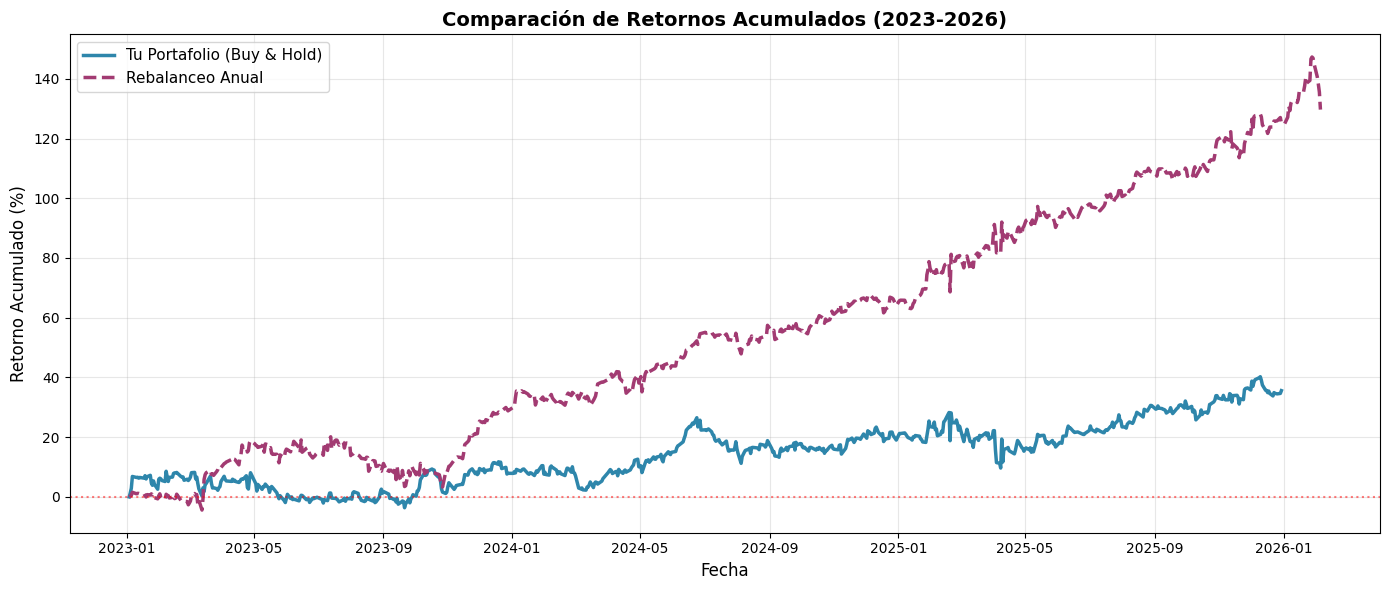

In [28]:
# Calcular valor del portafolio cada día
valor_portafolio = []

for i in range(len(precios)):
    valor_dia = 0
    for ticker, cantidad in portfolio_data.items():
        precio = precios.iloc[i][ticker]
        valor_dia += precio * cantidad
    valor_portafolio.append(valor_dia)

# Crear DataFrame con resultados
resultados_tu_portafolio = pd.DataFrame({
    'Valor_Portafolio': valor_portafolio
}, index=precios.index)

# Calcular retorno acumulado
inversion_inicial = valor_portafolio[0]
resultados_tu_portafolio['Retorno_Acumulado'] = (
    (resultados_tu_portafolio['Valor_Portafolio'] / inversion_inicial - 1) * 100
)

# COMPARACIÓN
print("="*80)
print("COMPARACIÓN DE RETORNOS ACUMULADOS")
print("="*80)

print(f"\nInversión Inicial: ${inversion_inicial:,.0f} COP")
print(f"\nValor Final Tu Portafolio: ${valor_portafolio[-1]:,.0f} COP")
print(f"Retorno Acumulado Tu Portafolio: {resultados_tu_portafolio['Retorno_Acumulado'].iloc[-1]:.2f}%")

print(f"\nValor Final Rebalanceo Anual: ${resultados_12m['Valor_Portafolio'].iloc[-1]:,.0f} COP")
print(f"Retorno Acumulado Rebalanceo Anual: {resultados_12m['Retorno_Acumulado'].iloc[-1]:.2f}%")

diferencia_retorno = resultados_12m['Retorno_Acumulado'].iloc[-1] - resultados_tu_portafolio['Retorno_Acumulado'].iloc[-1]
print(f"\nDiferencia: {diferencia_retorno:+.2f} puntos porcentuales")

if diferencia_retorno > 0:
    print(f"✅ El rebalanceo anual tuvo un retorno {abs(diferencia_retorno):.2f}% MAYOR")
else:
    print(f"✅ Tu portafolio tuvo un retorno {abs(diferencia_retorno):.2f}% MAYOR")

# GRÁFICO DE COMPARACIÓN
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(resultados_tu_portafolio.index, resultados_tu_portafolio['Retorno_Acumulado'], 
         label='Tu Portafolio (Buy & Hold)', linewidth=2.5, color='#2E86AB')
plt.plot(resultados_12m.index, resultados_12m['Retorno_Acumulado'], 
         label='Rebalanceo Anual', linewidth=2.5, color='#A23B72', linestyle='--')
plt.title('Comparación de Retornos Acumulados (2023-2026)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Retorno Acumulado (%)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.savefig('comparacion_retornos.png', dpi=300, bbox_inches='tight')
plt.show()


## Comparativa: Markowitz (Mínima Volatilidad) vs Kelly Criterion — Rebalanceo Semestral

In [29]:
def calcular_pesos_kelly(returns):
    """
    Calcula los pesos óptimos usando el Criterio de Kelly para múltiples activos.
    
    Kelly dice: f* = Σ^(-1) * μ
    Donde Σ es la matriz de covarianza y μ es el vector de retornos esperados.
    
    Se aplican restricciones: pesos >= 0, suma = 1 (sin apalancamiento ni cortos).
    """
    mu = returns.mean().values
    cov = returns.cov().values
    n = len(mu)
    
    # Kelly sin restricciones: f* = inv(Σ) * μ
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov)
    
    kelly_raw = cov_inv @ mu
    
    # Restricciones: pesos >= 0 y suman 1
    # Si hay pesos negativos, los ponemos a 0 y renormalizamos
    kelly_constrained = np.maximum(kelly_raw, 0)
    
    if kelly_constrained.sum() > 0:
        kelly_constrained = kelly_constrained / kelly_constrained.sum()
    else:
        # Fallback: equiponderado
        kelly_constrained = np.ones(n) / n
    
    return pd.Series(kelly_constrained, index=returns.columns)


# Verificación rápida con los datos de entrenamiento
precios_train = descargar_precios(portfolio, '2021-01-01', '2023-01-01', stocks_en_usd)
retornos_train = precios_train.pct_change().dropna()

pesos_kelly = calcular_pesos_kelly(retornos_train)
pesos_markowitz = calcular_pesos_minima_volatilidad(retornos_train)

print("Pesos iniciales (entrenamiento 2021-2023):")
print(f"{'Activo':<16} {'Markowitz':>12} {'Kelly':>12}")
print("-" * 42)
for ticker in portfolio:
    print(f"{ticker:<16} {pesos_markowitz[ticker]*100:>11.2f}% {pesos_kelly[ticker]*100:>11.2f}%")

Pesos iniciales (entrenamiento 2021-2023):
Activo              Markowitz        Kelly
------------------------------------------
ECOPETROL.CL            0.78%       11.49%
GEB.CL                 15.98%        0.00%
PFCIBEST.CL             9.15%        0.00%
CIBEST.CL               7.04%       19.11%
GOOGL                   0.00%        0.00%
AAPL                    0.00%        0.00%
BVC.CL                 31.67%        0.00%
NKE                     0.00%        0.00%
IVV                    35.38%       69.40%


In [30]:
def backtest_estrategia(portfolio, stocks_en_usd, fecha_inicio_entrenamiento, 
                        fecha_inicio_backtest, fecha_fin_backtest, 
                        meses_rebalanceo, funcion_pesos, inversion_inicial=10000000):
    """
    Backtest genérico: recibe la función de cálculo de pesos como parámetro.
    funcion_pesos: función que recibe returns y devuelve pd.Series de pesos.
    """
    precios_entrenamiento = descargar_precios(
        portfolio, fecha_inicio_entrenamiento, fecha_inicio_backtest, stocks_en_usd
    )
    precios_backtest = descargar_precios(
        portfolio, fecha_inicio_backtest, fecha_fin_backtest, stocks_en_usd
    )
    
    retornos_entrenamiento = precios_entrenamiento.pct_change().dropna()
    pesos_actuales = funcion_pesos(retornos_entrenamiento)
    
    valor_portafolio = [inversion_inicial]
    fechas_rebalanceo = [precios_backtest.index[0]]
    historial_pesos = [pesos_actuales.to_dict()]
    
    ultima_fecha_rebalanceo = precios_backtest.index[0]
    precio_inicial = precios_backtest.iloc[0]
    acciones = (pesos_actuales * inversion_inicial) / precio_inicial
    
    for i in range(1, len(precios_backtest)):
        fecha_actual = precios_backtest.index[i]
        precios_actual = precios_backtest.iloc[i]
        
        valor_actual = (acciones * precios_actual).sum()
        valor_portafolio.append(valor_actual)
        
        meses_transcurridos = (fecha_actual.year - ultima_fecha_rebalanceo.year) * 12 + \
                              (fecha_actual.month - ultima_fecha_rebalanceo.month)
        
        if meses_transcurridos >= meses_rebalanceo:
            precios_entrenamiento_actual = descargar_precios(
                portfolio, fecha_inicio_entrenamiento,
                fecha_actual.strftime('%Y-%m-%d'), stocks_en_usd
            )
            retornos_actual = precios_entrenamiento_actual.pct_change().dropna()
            pesos_actuales = funcion_pesos(retornos_actual)
            
            acciones = (pesos_actuales * valor_actual) / precios_actual
            ultima_fecha_rebalanceo = fecha_actual
            fechas_rebalanceo.append(fecha_actual)
            historial_pesos.append(pesos_actuales.to_dict())

    resultados = pd.DataFrame({'Valor_Portafolio': valor_portafolio}, index=precios_backtest.index)
    resultados['Retorno_Acumulado'] = (resultados['Valor_Portafolio'] / inversion_inicial - 1) * 100
    resultados['Retorno_Diario'] = resultados['Valor_Portafolio'].pct_change()
    
    retorno_total = (valor_portafolio[-1] / inversion_inicial - 1) * 100
    n_dias = len(precios_backtest)
    retorno_anualizado = ((valor_portafolio[-1] / inversion_inicial) ** (252 / n_dias) - 1) * 100
    volatilidad_anualizada = resultados['Retorno_Diario'].std() * np.sqrt(252) * 100
    sharpe_ratio = retorno_anualizado / volatilidad_anualizada if volatilidad_anualizada > 0 else 0
    
    cummax = resultados['Valor_Portafolio'].cummax()
    drawdown = (resultados['Valor_Portafolio'] - cummax) / cummax * 100
    max_drawdown = drawdown.min()
    
    metricas = {
        'Retorno Total (%)': retorno_total,
        'Retorno Anualizado (%)': retorno_anualizado,
        'Volatilidad Anualizada (%)': volatilidad_anualizada,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Num Rebalanceos': len(fechas_rebalanceo) - 1
    }
    
    return resultados, metricas, fechas_rebalanceo, historial_pesos

print("Función backtest_estrategia definida.")

Función backtest_estrategia definida.


In [31]:
# --- EJECUTAR COMPARATIVA SEMESTRAL ---
print("Ejecutando backtest Markowitz vs Kelly con rebalanceo semestral...")
print("=" * 80)

fecha_inicio_entrenamiento = '2021-01-01'
fecha_inicio_backtest = '2023-01-01'
fecha_fin_backtest = datetime.now().strftime('%Y-%m-%d')
inversion_inicial = 41267106

# Markowitz (Mínima Volatilidad) — Semestral
print("\n1. MARKOWITZ (Mínima Volatilidad) — Semestral")
print("-" * 60)
res_markowitz, met_markowitz, fechas_m, pesos_m = backtest_estrategia(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento, fecha_inicio_backtest, fecha_fin_backtest,
    meses_rebalanceo=6,
    funcion_pesos=calcular_pesos_minima_volatilidad,
    inversion_inicial=inversion_inicial
)
for k, v in met_markowitz.items():
    print(f"  {k}: {v:.2f}")

# Kelly Criterion — Semestral
print("\n2. KELLY CRITERION — Semestral")
print("-" * 60)
res_kelly, met_kelly, fechas_k, pesos_k = backtest_estrategia(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento, fecha_inicio_backtest, fecha_fin_backtest,
    meses_rebalanceo=6,
    funcion_pesos=calcular_pesos_kelly,
    inversion_inicial=inversion_inicial
)
for k, v in met_kelly.items():
    print(f"  {k}: {v:.2f}")

Ejecutando backtest Markowitz vs Kelly con rebalanceo semestral...

1. MARKOWITZ (Mínima Volatilidad) — Semestral
------------------------------------------------------------
  Retorno Total (%): 121.80
  Retorno Anualizado (%): 31.60
  Volatilidad Anualizada (%): 17.31
  Sharpe Ratio: 1.83
  Max Drawdown (%): -11.25
  Num Rebalanceos: 6.00

2. KELLY CRITERION — Semestral
------------------------------------------------------------
  Retorno Total (%): 63.68
  Retorno Anualizado (%): 18.51
  Volatilidad Anualizada (%): 17.26
  Sharpe Ratio: 1.07
  Max Drawdown (%): -14.54
  Num Rebalanceos: 6.00


In [32]:
# --- TABLA COMPARATIVA ---
print("=" * 80)
print("TABLA COMPARATIVA — REBALANCEO SEMESTRAL")
print("=" * 80)

comparativa = pd.DataFrame({
    'Markowitz (Min Vol)': met_markowitz,
    'Kelly Criterion': met_kelly
})
print(comparativa.round(2))

print(f"\nValor final Markowitz:  ${res_markowitz['Valor_Portafolio'].iloc[-1]:,.0f} COP")
print(f"Valor final Kelly:     ${res_kelly['Valor_Portafolio'].iloc[-1]:,.0f} COP")

diff = res_kelly['Valor_Portafolio'].iloc[-1] - res_markowitz['Valor_Portafolio'].iloc[-1]
print(f"\nDiferencia Kelly - Markowitz: ${diff:+,.0f} COP")


TABLA COMPARATIVA — REBALANCEO SEMESTRAL
                            Markowitz (Min Vol)  Kelly Criterion
Retorno Total (%)                        121.80            63.68
Retorno Anualizado (%)                    31.60            18.51
Volatilidad Anualizada (%)                17.31            17.26
Sharpe Ratio                               1.83             1.07
Max Drawdown (%)                         -11.25           -14.54
Num Rebalanceos                            6.00             6.00

Valor final Markowitz:  $91,532,254 COP
Valor final Kelly:     $67,545,015 COP

Diferencia Kelly - Markowitz: $-23,987,239 COP


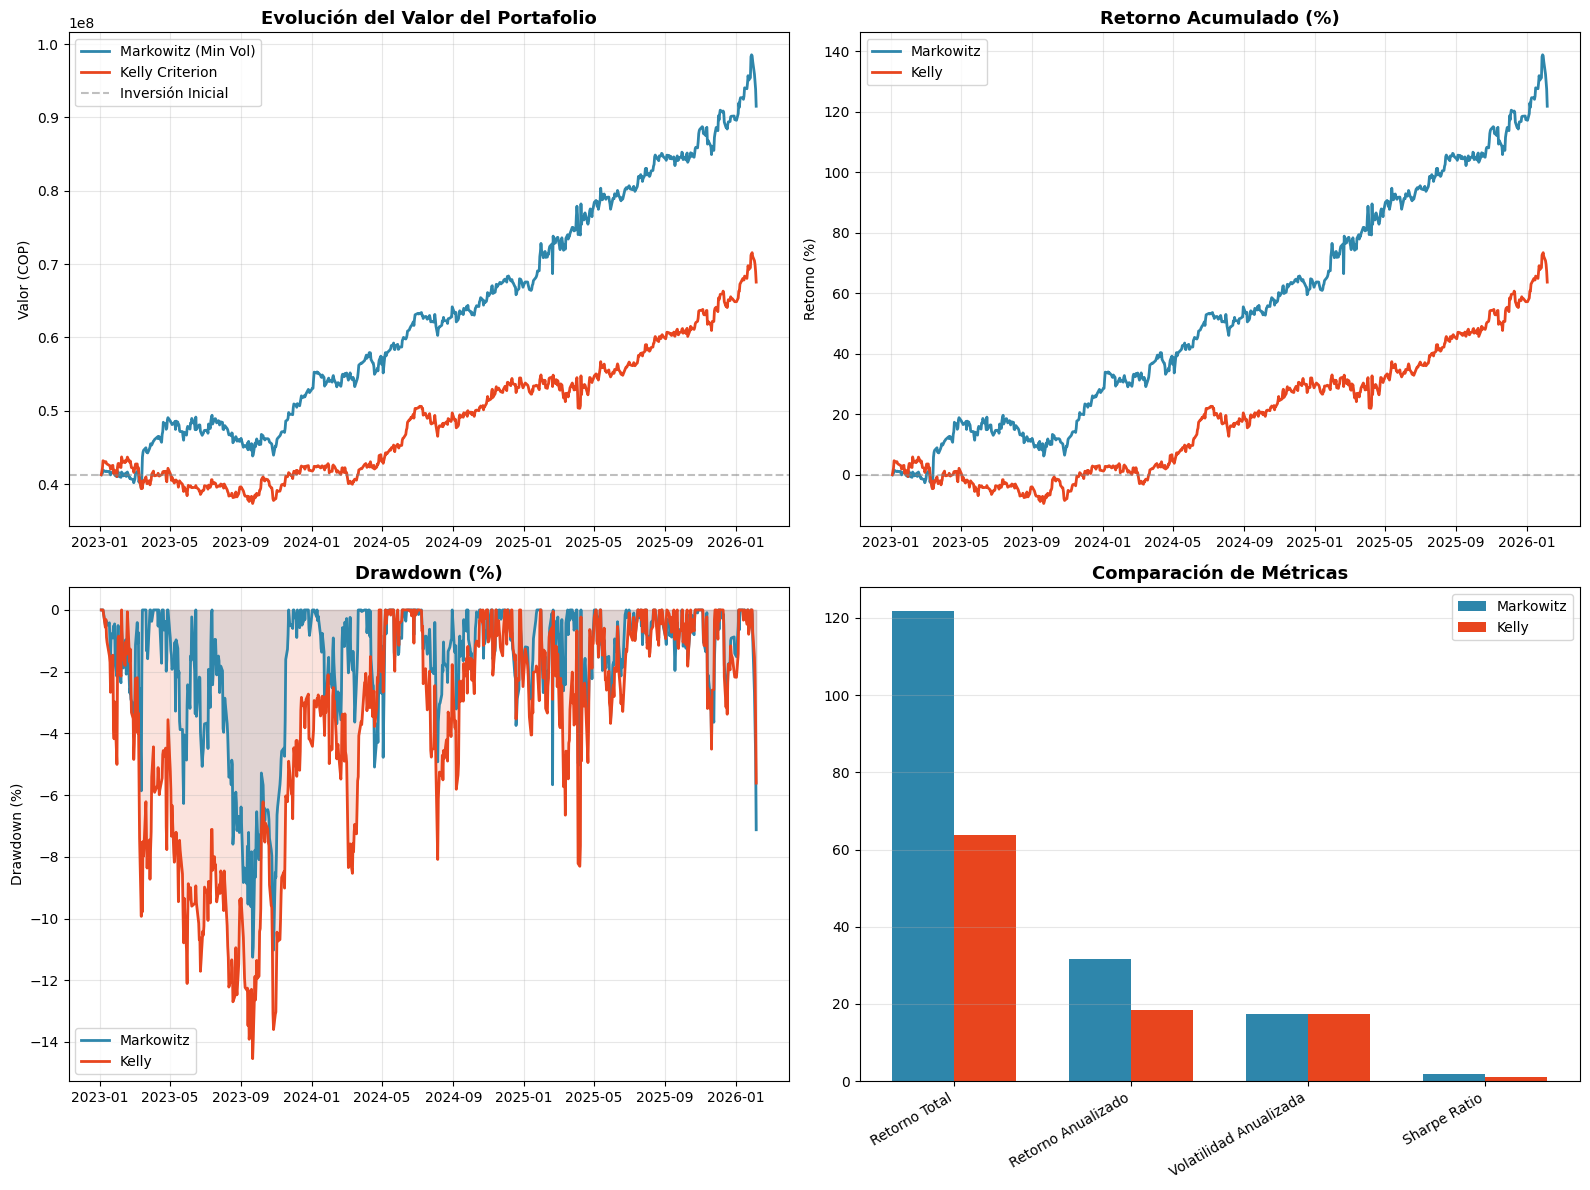

In [33]:
# --- GRÁFICOS COMPARATIVOS ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolución del valor del portafolio
ax1 = axes[0, 0]
ax1.plot(res_markowitz.index, res_markowitz['Valor_Portafolio'], 
         label='Markowitz (Min Vol)', linewidth=2, color='#2E86AB')
ax1.plot(res_kelly.index, res_kelly['Valor_Portafolio'], 
         label='Kelly Criterion', linewidth=2, color='#E8451E')
ax1.axhline(y=inversion_inicial, color='gray', linestyle='--', alpha=0.5, label='Inversión Inicial')
ax1.set_title('Evolución del Valor del Portafolio', fontsize=13, fontweight='bold')
ax1.set_ylabel('Valor (COP)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Retorno acumulado
ax2 = axes[0, 1]
ax2.plot(res_markowitz.index, res_markowitz['Retorno_Acumulado'], 
         label='Markowitz', linewidth=2, color='#2E86AB')
ax2.plot(res_kelly.index, res_kelly['Retorno_Acumulado'], 
         label='Kelly', linewidth=2, color='#E8451E')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Retorno Acumulado (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Retorno (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Drawdown
ax3 = axes[1, 0]
for nombre, resultado, color in [('Markowitz', res_markowitz, '#2E86AB'), 
                                   ('Kelly', res_kelly, '#E8451E')]:
    cummax = resultado['Valor_Portafolio'].cummax()
    dd = (resultado['Valor_Portafolio'] - cummax) / cummax * 100
    ax3.plot(resultado.index, dd, label=nombre, linewidth=2, color=color)
    ax3.fill_between(resultado.index, dd, 0, alpha=0.15, color=color)
ax3.set_title('Drawdown (%)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Drawdown (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Comparación de métricas clave
ax4 = axes[1, 1]
metricas_plot = ['Retorno Total (%)', 'Retorno Anualizado (%)', 'Volatilidad Anualizada (%)', 'Sharpe Ratio']
x = np.arange(len(metricas_plot))
width = 0.35
vals_m = [met_markowitz[m] for m in metricas_plot]
vals_k = [met_kelly[m] for m in metricas_plot]
bars1 = ax4.bar(x - width/2, vals_m, width, label='Markowitz', color='#2E86AB')
bars2 = ax4.bar(x + width/2, vals_k, width, label='Kelly', color='#E8451E')
ax4.set_xticks(x)
ax4.set_xticklabels([m.replace(' (%)', '') for m in metricas_plot], rotation=30, ha='right')
ax4.set_title('Comparación de Métricas', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('markowitz_vs_kelly_semestral.png', dpi=300, bbox_inches='tight')
plt.show()

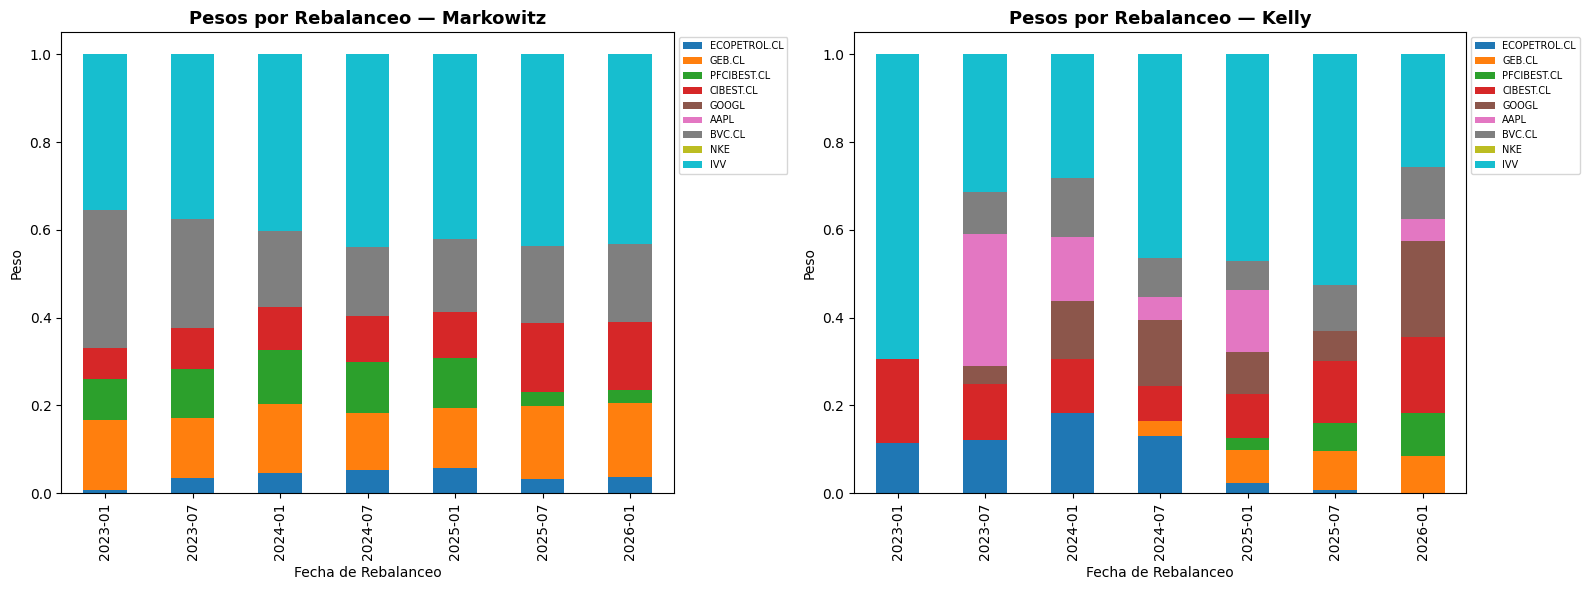

In [34]:
# --- EVOLUCIÓN DE PESOS EN CADA REBALANCEO ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Markowitz
pesos_m_df = pd.DataFrame(pesos_m, index=[f.strftime('%Y-%m') for f in fechas_m])
pesos_m_df.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab10')
axes[0].set_title('Pesos por Rebalanceo — Markowitz', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Peso')
axes[0].set_xlabel('Fecha de Rebalanceo')
axes[0].legend(bbox_to_anchor=(1.0, 1.0), fontsize=7)
axes[0].set_ylim(0, 1.05)

# Kelly
pesos_k_df = pd.DataFrame(pesos_k, index=[f.strftime('%Y-%m') for f in fechas_k])
pesos_k_df.plot(kind='bar', stacked=True, ax=axes[1], colormap='tab10')
axes[1].set_title('Pesos por Rebalanceo — Kelly', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Peso')
axes[1].set_xlabel('Fecha de Rebalanceo')
axes[1].legend(bbox_to_anchor=(1.0, 1.0), fontsize=7)
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('evolucion_pesos_markowitz_vs_kelly.png', dpi=300, bbox_inches='tight')
plt.show()

Problematicas con kelly, como el $\mu$ lo estamos calculando con algunos valores historicos, el criterio de kelly en este caso particular asigna mayores pesos a acciones que vienen obteniendo buenos retornos. Lo que viola uno de los principios fundamentales de la inversion "Comprar barato y vender caro". Surge entonces la pregunta que otros metodos podemos aplicar para obtener los retornos esperados? En el caso particular de la musica. Me sirve obtener los retornos esperados a traves de series de tiempo?